# HotpotQA Answer Generation Quality Evaluation Framework

## Overview

This notebook implements **6 evaluation metrics** for HotpotQA answer generation quality assessment:

1. **Answer F1** - Token-level overlap measuring partial credit for answers
2. **Answer EM** - Exact match for strict answer correctness evaluation  
3. **Citation Precision** - Percentage of predicted citations that are correct
4. **Citation Recall** - Percentage of ground truth citations correctly identified
5. **Citation F1** - Harmonic mean of citation precision and recall
6. **Insufficient Context Detection Rate** - Accuracy when model identifies unanswerable questions

## Generation Quality vs Retrieval Evaluation

This framework evaluates **generation quality** - how well the model produces accurate answers with proper citation support. This is **separate from retrieval evaluation**, which measures document/passage selection quality (covered separately).

### Why These 6 Metrics?

**Answer Metrics (F1 & EM)**:
- Standard QA evaluation providing both lenient (F1) and strict (EM) assessment
- Comparable to major benchmarks (SQuAD, Natural Questions)
- F1 gives partial credit for semantically similar answers

**Citation Metrics (Precision, Recall, F1)**:
- Unique to RAG systems - ensures factual grounding
- Prevents citation hallucination and random guessing
- Critical for explainability and trustworthiness
- Tests multihop reasoning by checking if all evidence is identified

**Insufficient Context Detection**:
- Tests model's ability to recognize limitations
- Prevents hallucination on unanswerable questions
- Critical for reliable deployment in production

This comprehensive framework evaluates answer correctness, citation accuracy, and edge case handling - the three pillars of trustworthy RAG systems.

In [ ]:
# Import required libraries for answer generation quality evaluation

import re

import string

import numpy as np

import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt

import seaborn as sns

from typing import List, Dict, Tuple, Union, Any

import warnings

warnings.filterwarnings('ignore')



print("✅ Answer generation quality evaluation libraries imported successfully!")

print("📊 Ready to implement the 6 generation quality metrics:")

print("   1. Answer F1 - Token-level answer similarity")

print("   2. Answer EM - Exact answer matching") 

print("   3. Citation Precision - Accuracy of predicted citations")

print("   4. Citation Recall - Completeness of citation identification")

print("   5. Citation F1 - Balanced citation quality metric")

print("   6. Insufficient Context Detection - Edge case handling")

print("🎯 Designed for comprehensive RAG answer generation assessment")

✅ Answer generation quality evaluation libraries imported successfully!
📊 Ready to implement the 6 generation quality metrics:
   1. Answer F1 - Token-level answer similarity
   2. Answer EM - Exact answer matching
   3. Citation Precision - Accuracy of predicted citations
   4. Citation Recall - Completeness of citation identification
   5. Citation F1 - Balanced citation quality metric
   6. Insufficient Context Detection - Edge case handling
🎯 Designed for comprehensive RAG answer generation assessment


In [ ]:


# DEBUG: Sample size reduction for quick testing

SAMPLE_SIZE = 10

print(f"🔍 DEBUG MODE: Using SAMPLE_SIZE={SAMPLE_SIZE}")


🔍 DEBUG MODE: Using SAMPLE_SIZE=10


In [ ]:
class HotpotQAGenerationEvaluator:

    """

    Answer generation quality evaluation framework for HotpotQA RAG systems

    

    Implements the 6 chosen generation quality metrics:

    1. Answer F1 - Token-level answer overlap

    2. Answer EM - Exact answer matching

    3. Citation Precision - Accuracy of predicted citations

    4. Citation Recall - Completeness of citation identification

    5. Citation F1 - Balanced citation quality

    6. Insufficient Context Detection - Edge case handling accuracy

    """

    

    def __init__(self):

        print("🎯 HotpotQA Generation Quality Evaluator Initialized")

        print("   📊 6 Generation Quality Metrics:")

        print("   • Answer F1 & EM (answer correctness)")

        print("   • Citation Precision, Recall & F1 (factual grounding)")

        print("   • Insufficient Context Detection (reliability)")

    

    def normalize_answer(self, text: str) -> str:

        """Standard answer normalization for HotpotQA evaluation"""

        def remove_articles(text):

            return re.sub(r'\b(a|an|the)\b', ' ', text)

        

        def white_space_fix(text):

            return ' '.join(text.split())

        

        def remove_punc(text):

            exclude = set(string.punctuation)

            return ''.join(ch for ch in text if ch not in exclude)

        

        def lower(text):

            return text.lower()

        

        return white_space_fix(remove_articles(remove_punc(lower(text))))

    

    def answer_exact_match(self, prediction: str, ground_truth: str) -> float:

        """

        Calculate Answer Exact Match score

        

        Returns 1.0 if normalized prediction exactly matches ground truth, else 0.0

        Special handling: Both "insufficient context" = 1.0

        """

        # Check for insufficient context case

        pred_insufficient = self.normalize_answer(prediction) == 'insufficient context'

        gt_insufficient = self.normalize_answer(ground_truth) == 'insufficient context'

        

        if gt_insufficient and pred_insufficient:

            return 1.0

        

        return float(self.normalize_answer(prediction) == self.normalize_answer(ground_truth))

    

    def answer_f1(self, prediction: str, ground_truth: str) -> float:

        """

        Calculate Answer F1 score at token level

        

        Measures overlap between predicted and ground truth answer tokens.

        Special handling: Both "insufficient context" = 1.0

        """

        # Check for insufficient context case

        pred_insufficient = self.normalize_answer(prediction) == 'insufficient context'

        gt_insufficient = self.normalize_answer(ground_truth) == 'insufficient context'

        

        if gt_insufficient and pred_insufficient:

            return 1.0

        

        pred_tokens = self.normalize_answer(prediction).split()

        gt_tokens = self.normalize_answer(ground_truth).split()

        

        if len(pred_tokens) == 0 and len(gt_tokens) == 0:

            return 1.0

        if len(pred_tokens) == 0 or len(gt_tokens) == 0:

            return 0.0

        

        common_tokens = Counter(pred_tokens) & Counter(gt_tokens)

        num_same = sum(common_tokens.values())

        

        if num_same == 0:

            return 0.0

        

        precision = num_same / len(pred_tokens)

        recall = num_same / len(gt_tokens)

        

        return 2 * precision * recall / (precision + recall)

    

    def citation_precision(self, pred_citations: List[int], gold_citations: List[int]) -> float:

        """

        Calculate Citation Precision

        

        Formula: (Correct predicted citations) / (Total predicted citations)

        Measures accuracy - prevents hallucinated citations

        Special handling: Empty predictions with "insufficient context" = 1.0

        """

        if not pred_citations:

            # If no predictions and gold is also empty, perfect precision

            return 1.0 if not gold_citations else 0.0

        

        pred_set = set(pred_citations)

        gold_set = set(gold_citations)

        

        correct = len(pred_set & gold_set)

        return correct / len(pred_set)

    

    def citation_recall(self, pred_citations: List[int], gold_citations: List[int]) -> float:

        """

        Calculate Citation Recall

        

        Formula: (Correct predicted citations) / (Total ground truth citations)

        Measures completeness - ensures all evidence is identified

        Special handling: Empty gold with "insufficient context" = 1.0

        """

        if not gold_citations:

            # If no gold citations and predictions are also empty, perfect recall

            return 1.0 if not pred_citations else 0.0

        

        pred_set = set(pred_citations)

        gold_set = set(gold_citations)

        

        correct = len(pred_set & gold_set)

        return correct / len(gold_set)

    

    def citation_f1(self, pred_citations: List[int], gold_citations: List[int]) -> float:

        """

        Calculate Citation F1 Score

        

        Formula: 2 × (Precision × Recall) / (Precision + Recall)

        Balances citation accuracy and completeness

        """

        precision = self.citation_precision(pred_citations, gold_citations)

        recall = self.citation_recall(pred_citations, gold_citations)

        

        if precision + recall == 0:

            return 0.0

        

        return 2 * precision * recall / (precision + recall)

    

    def insufficient_context_detection(self, prediction: str, ground_truth: str) -> float:

        """

        Calculate Insufficient Context Detection Rate

        

        Returns 1.0 when model correctly identifies insufficient context cases

        Returns 0.0 when model fails to recognize insufficient context

        Only applies when ground truth is "insufficient context"

        """

        gt_insufficient = self.normalize_answer(ground_truth) == 'insufficient context'

        

        if not gt_insufficient:

            # Not an insufficient context case, return None (not applicable)

            return None

        

        pred_insufficient = self.normalize_answer(prediction) == 'insufficient context'

        return float(pred_insufficient)

    

    def evaluate_single(self, prediction: Dict, gold_data: Dict) -> Dict[str, float]:

        """

        Evaluate a single HotpotQA prediction with all 6 generation quality metrics

        

        Args:

            prediction: {

                'answer': str,

                'citations': List[int]  # List of supporting passage indices

            }

            gold_data: {

                'answer': str,

                'citations': List[int]

            }

            

        Returns:

            Dictionary with all 6 evaluation metrics

        """

        # 1. Answer F1

        ans_f1 = self.answer_f1(prediction['answer'], gold_data['answer'])

        

        # 2. Answer EM

        ans_em = self.answer_exact_match(prediction['answer'], gold_data['answer'])

        

        # 3. Citation Precision

        cit_precision = self.citation_precision(

            prediction.get('citations', []), 

            gold_data.get('citations', [])

        )

        

        # 4. Citation Recall

        cit_recall = self.citation_recall(

            prediction.get('citations', []), 

            gold_data.get('citations', [])

        )

        

        # 5. Citation F1

        cit_f1 = self.citation_f1(

            prediction.get('citations', []), 

            gold_data.get('citations', [])

        )

        

        # 6. Insufficient Context Detection (may be None if not applicable)

        insuf_detection = self.insufficient_context_detection(

            prediction['answer'], 

            gold_data['answer']

        )

        

        return {

            'answer_f1': ans_f1,

            'answer_em': ans_em,

            'citation_precision': cit_precision,

            'citation_recall': cit_recall,

            'citation_f1': cit_f1,

            'insufficient_context_detection': insuf_detection

        }

    

    def evaluate_batch(self, predictions: List[Dict], gold_data: List[Dict]) -> Dict[str, float]:

        """

        Evaluate a batch of HotpotQA predictions

        

        Returns averages of all 6 generation quality metrics.

        Insufficient context detection is averaged only over applicable cases.

        """

        if len(predictions) != len(gold_data):

            raise ValueError("Predictions and gold data must have the same length")

        

        all_metrics = {

            'answer_f1': [],

            'answer_em': [],

            'citation_precision': [],

            'citation_recall': [],

            'citation_f1': [],

            'insufficient_context_detection': []

        }

        

        for pred, gold in zip(predictions, gold_data):

            single_result = self.evaluate_single(pred, gold)

            

            for metric, value in single_result.items():

                if value is not None:  # Only include non-None values

                    all_metrics[metric].append(value)

        

        # Calculate averages (insufficient context detection averaged over applicable cases only)

        return {

            metric: np.mean(scores) if scores else 0.0 

            for metric, scores in all_metrics.items()

        }



# Initialize evaluator

evaluator = HotpotQAGenerationEvaluator()

print("\n✅ HotpotQA Generation Quality Evaluator initialized successfully!")

print("🚀 Ready for comprehensive answer generation evaluation with citation accuracy!")

🎯 HotpotQA Generation Quality Evaluator Initialized
   📊 6 Generation Quality Metrics:
   • Answer F1 & EM (answer correctness)
   • Citation Precision, Recall & F1 (factual grounding)
   • Insufficient Context Detection (reliability)

✅ HotpotQA Generation Quality Evaluator initialized successfully!
🚀 Ready for comprehensive answer generation evaluation with citation accuracy!


## Understanding the 6 Generation Quality Metrics

This evaluation framework measures **answer generation quality** across three dimensions:

### 1. Answer Correctness (F1 & EM)
- **Answer F1**: Token-level overlap providing partial credit for semantically similar answers
- **Answer EM**: Strict binary metric requiring exact match after normalization

### 2. Citation Accuracy (Precision, Recall, F1)
- **Citation Precision**: Prevents hallucinated citations - measures accuracy
- **Citation Recall**: Ensures complete evidence chains - measures completeness  
- **Citation F1**: Balanced metric combining precision and recall

### 3. Edge Case Handling (Insufficient Context Detection)
- Tests model's ability to recognize when questions cannot be answered
- Prevents confident wrong answers on unanswerable questions
- Critical for deployment reliability

### Why This Matters for RAG Systems

Unlike traditional QA, RAG systems must not only generate correct answers but also:
1. **Cite sources accurately** - Preventing fabricated evidence
2. **Identify all required evidence** - Demonstrating complete reasoning
3. **Recognize limitations** - Admitting when context is insufficient

These 6 metrics comprehensively evaluate all three requirements.

In [ ]:
# Demonstration of 6 Generation Quality Metrics

print("🎯 GENERATION QUALITY METRICS DEMONSTRATION")

print("="*60)

print("Testing comprehensive evaluation with realistic HotpotQA examples\n")



# Create realistic examples showcasing different generation quality scenarios

generation_examples = [

    {

        "name": "Perfect Generation",

        "description": "Correct answer with accurate and complete citations",

        "question": "Which magazine was started first Arthur's Magazine or First for Women?",

        "gold_data": {

            'answer': "Arthur's Magazine",

            'citations': [1, 2]  # Both supporting passages

        },

        "prediction": {

            'answer': "Arthur's Magazine",

            'citations': [1, 2]

        }

    },

    {

        "name": "Partial Answer Match",

        "description": "Semantically close answer with perfect citations",

        "question": "How is COVID-19 primarily transmitted?",

        "gold_data": {

            'answer': "respiratory droplets and aerosols",

            'citations': [1, 3]

        },

        "prediction": {

            'answer': "respiratory droplets",  # Partial but semantically similar

            'citations': [1, 3]

        }

    },

    {

        "name": "Citation Precision Issue",

        "description": "Correct answer but includes incorrect citation",

        "question": "What position did the drafted player play?",

        "gold_data": {

            'answer': "point guard",

            'citations': [2, 4]

        },

        "prediction": {

            'answer': "point guard",

            'citations': [2, 4, 5]  # Added wrong citation

        }

    },

    {

        "name": "Citation Recall Issue",

        "description": "Correct answer but missing required citation",

        "question": "What year was the magazine founded?",

        "gold_data": {

            'answer': "1844",

            'citations': [1, 3]

        },

        "prediction": {

            'answer': "1844",

            'citations': [1]  # Missing citation 3

        }

    },

    {

        "name": "Perfect Insufficient Context Detection",

        "description": "Correctly identifies unanswerable question",

        "question": "What is the population of the fictional city?",

        "gold_data": {

            'answer': "insufficient context",

            'citations': []

        },

        "prediction": {

            'answer': "insufficient context",

            'citations': []

        }

    },

    {

        "name": "Failed Insufficient Context Detection",

        "description": "Hallucinates answer when should say insufficient context",

        "question": "What is the exact profit margin mentioned?",

        "gold_data": {

            'answer': "insufficient context",

            'citations': []

        },

        "prediction": {

            'answer': "25 percent",  # Hallucinated answer

            'citations': [2]

        }

    },

    {

        "name": "Complete Failure",

        "description": "Wrong answer with wrong citations",

        "question": "Which company founded by Elon Musk focuses on space travel?",

        "gold_data": {

            'answer': "SpaceX",

            'citations': [1, 3]

        },

        "prediction": {

            'answer': "Tesla",

            'citations': [2]

        }

    }

]



print("📊 EVALUATION RESULTS FOR EACH SCENARIO:")

print("="*60)



results_summary = []



for example in generation_examples:

    print(f"\n🔍 {example['name']}")

    print(f"   {example['description']}")

    print(f"   Q: {example['question']}")

    print("-" * 50)

    

    # Evaluate the example

    result = evaluator.evaluate_single(example['prediction'], example['gold_data'])

    

    # Display all 6 metrics

    print(f"📋 Metrics:")

    print(f"   1. Answer F1:           {result['answer_f1']:.3f}")

    print(f"   2. Answer EM:           {result['answer_em']:.3f}")

    print(f"   3. Citation Precision:  {result['citation_precision']:.3f}")

    print(f"   4. Citation Recall:     {result['citation_recall']:.3f}")

    print(f"   5. Citation F1:         {result['citation_f1']:.3f}")

    

    # Insufficient context detection (only applicable for some cases)

    if result['insufficient_context_detection'] is not None:

        print(f"   6. Insuf. Context Det.: {result['insufficient_context_detection']:.3f}")

    else:

        print(f"   6. Insuf. Context Det.: N/A (not applicable)")

    

    # Add to summary

    row = {

        'Scenario': example['name'],

        'Ans_F1': f"{result['answer_f1']:.3f}",

        'Ans_EM': f"{result['answer_em']:.3f}",

        'Cit_Prec': f"{result['citation_precision']:.3f}",

        'Cit_Rec': f"{result['citation_recall']:.3f}",

        'Cit_F1': f"{result['citation_f1']:.3f}"

    }

    results_summary.append(row)

    

    # Performance insights

    print(f"💡 Insight:", end=" ")

    if result['answer_f1'] == 1.0 and result['citation_f1'] == 1.0:

        print("Perfect generation - answer and citations both correct!")

    elif result['answer_f1'] > result['answer_em']:

        print("F1 captures partial credit where EM gives 0.0")

    elif result['citation_precision'] < 1.0:

        print("Citation hallucination - includes incorrect citations")

    elif result['citation_recall'] < 1.0:

        print("Incomplete evidence - missing required citations")

    elif result['insufficient_context_detection'] == 0.0:

        print("Failed to recognize unanswerable question - reliability issue")

    elif result['insufficient_context_detection'] == 1.0:

        print("Correctly identified insufficient context - reliable system")

    else:

        print("Complete failure in answer generation")



# Create summary table

print(f"\n📊 SUMMARY TABLE:")

print("="*90)

summary_df = pd.DataFrame(results_summary)

print(summary_df.to_string(index=False))



print(f"\n💡 KEY INSIGHTS:")

print("="*50)

print("1. 🎯 Answer F1 vs EM: F1 rewards partial semantic similarity")

print("2. 🔍 Citation Precision: Prevents hallucinated citations")

print("3. 📚 Citation Recall: Ensures complete evidence chains")

print("4. ⚖️ Citation F1: Balances accuracy and completeness")

print("5. 🔐 Insufficient Context: Critical for reliable deployments")

print("6. 📊 Together: Comprehensive answer generation assessment")



print(f"\n🚀 This framework evaluates:")

print("• Answer correctness (both strict and lenient)")

print("• Citation accuracy (prevents hallucination)")

print("• Citation completeness (ensures full reasoning)")

print("• Edge case handling (recognizes limitations)")

🎯 GENERATION QUALITY METRICS DEMONSTRATION
Testing comprehensive evaluation with realistic HotpotQA examples

📊 EVALUATION RESULTS FOR EACH SCENARIO:

🔍 Perfect Generation
   Correct answer with accurate and complete citations
   Q: Which magazine was started first Arthur's Magazine or First for Women?
--------------------------------------------------
📋 Metrics:
   1. Answer F1:           1.000
   2. Answer EM:           1.000
   3. Citation Precision:  1.000
   4. Citation Recall:     1.000
   5. Citation F1:         1.000
   6. Insuf. Context Det.: N/A (not applicable)
💡 Insight: Perfect generation - answer and citations both correct!

🔍 Partial Answer Match
   Semantically close answer with perfect citations
   Q: How is COVID-19 primarily transmitted?
--------------------------------------------------
📋 Metrics:
   1. Answer F1:           0.667
   2. Answer EM:           0.000
   3. Citation Precision:  1.000
   4. Citation Recall:     1.000
   5. Citation F1:         1.000
   6. 

In [ ]:
# Batch Evaluation Example

print("📊 BATCH EVALUATION WITH 6 GENERATION QUALITY METRICS")

print("="*60)

print("Demonstrating batch evaluation for RAG system assessment\n")



# Simulate batch predictions from a RAG system

batch_predictions = [

    {

        'answer': "Arthur's Magazine",

        'citations': [1, 2]

    },

    {

        'answer': "respiratory droplets",

        'citations': [1, 3]

    },

    {

        'answer': "point guard",

        'citations': [2, 4, 5]  # Extra citation

    },

    {

        'answer': "1844",

        'citations': [1]  # Missing citation

    },

    {

        'answer': "insufficient context",

        'citations': []

    },

    {

        'answer': "2.5 million",

        'citations': [1, 2]

    },

    {

        'answer': "Tesla",  # Wrong answer

        'citations': [2]

    },

    {

        'answer': "insufficient context",

        'citations': []

    }

]



# Corresponding ground truth data

batch_gold_data = [

    {

        'answer': "Arthur's Magazine",

        'citations': [1, 2]

    },

    {

        'answer': "respiratory droplets and aerosols",

        'citations': [1, 3]

    },

    {

        'answer': "point guard",

        'citations': [2, 4]

    },

    {

        'answer': "1844",

        'citations': [1, 3]

    },

    {

        'answer': "insufficient context",

        'citations': []

    },

    {

        'answer': "2.5 million",

        'citations': [1, 2]

    },

    {

        'answer': "SpaceX",

        'citations': [1, 3]

    },

    {

        'answer': "insufficient context",

        'citations': []

    }

]



print("🎯 Evaluating batch of 8 predictions...")



# Perform batch evaluation

batch_results = evaluator.evaluate_batch(batch_predictions, batch_gold_data)



print(f"\n📊 BATCH EVALUATION RESULTS (Average across 8 examples):")

print("="*60)

print(f"1. Answer F1:                    {batch_results['answer_f1']:.3f}")

print(f"2. Answer EM:                    {batch_results['answer_em']:.3f}")

print(f"3. Citation Precision:           {batch_results['citation_precision']:.3f}")

print(f"4. Citation Recall:              {batch_results['citation_recall']:.3f}")

print(f"5. Citation F1:                  {batch_results['citation_f1']:.3f}")

print(f"6. Insufficient Context Detection: {batch_results['insufficient_context_detection']:.3f}")



# Per-example detailed analysis

print(f"\n📝 DETAILED PER-EXAMPLE ANALYSIS:")

print("="*90)



detailed_results = []

for i, (pred, gold) in enumerate(zip(batch_predictions, batch_gold_data)):

    result = evaluator.evaluate_single(pred, gold)

    

    insuf_str = f"{result['insufficient_context_detection']:.3f}" if result['insufficient_context_detection'] is not None else "N/A"

    

    row = {

        "Ex": f"#{i+1}",

        "Ans_F1": f"{result['answer_f1']:.3f}",

        "Ans_EM": f"{result['answer_em']:.3f}",

        "Cit_Prec": f"{result['citation_precision']:.3f}",

        "Cit_Rec": f"{result['citation_recall']:.3f}",

        "Cit_F1": f"{result['citation_f1']:.3f}",

        "Insuf_Det": insuf_str

    }

    detailed_results.append(row)



detailed_df = pd.DataFrame(detailed_results)

print(detailed_df.to_string(index=False))



# Performance insights

print(f"\n🔍 BATCH PERFORMANCE INSIGHTS:")

print("="*50)



# Count success metrics

perfect_answer_em = sum(1 for result in detailed_results if float(result['Ans_EM']) == 1.0)

perfect_citation_f1 = sum(1 for result in detailed_results if float(result['Cit_F1']) == 1.0)

insuf_cases = sum(1 for result in detailed_results if result['Insuf_Det'] != "N/A")



print(f"📊 Success Rates:")

print(f"   • Perfect Answer EM: {perfect_answer_em}/8 ({(perfect_answer_em/8)*100:.0f}%)")

print(f"   • Perfect Citation F1: {perfect_citation_f1}/8 ({(perfect_citation_f1/8)*100:.0f}%)")

print(f"   • Insufficient Context Cases: {insuf_cases}/8 ({(insuf_cases/8)*100:.0f}%)")



print(f"\n💡 KEY OBSERVATIONS:")

print("• Answer EM is strict - requires perfect match")

print("• Answer F1 captures partial semantic overlap")

print("• Citation metrics reveal evidence selection quality")

print("• Insufficient context detection measures reliability")

print("• Together: Comprehensive generation quality assessment")



print(f"\n🚀 USE CASES FOR BATCH EVALUATION:")

print("• Compare different RAG system variants")

print("• Track model improvements over time")

print("• Identify systematic failure patterns")

print("• Validate citation accuracy and completeness")

print("• Ensure reliable handling of edge cases")

📊 BATCH EVALUATION WITH 6 GENERATION QUALITY METRICS
Demonstrating batch evaluation for RAG system assessment

🎯 Evaluating batch of 8 predictions...

📊 BATCH EVALUATION RESULTS (Average across 8 examples):
1. Answer F1:                    0.833
2. Answer EM:                    0.750
3. Citation Precision:           0.833
4. Citation Recall:              0.812
5. Citation F1:                  0.808
6. Insufficient Context Detection: 1.000

📝 DETAILED PER-EXAMPLE ANALYSIS:
Ex Ans_F1 Ans_EM Cit_Prec Cit_Rec Cit_F1 Insuf_Det
#1  1.000  1.000    1.000   1.000  1.000       N/A
#2  0.667  0.000    1.000   1.000  1.000       N/A
#3  1.000  1.000    0.667   1.000  0.800       N/A
#4  1.000  1.000    1.000   0.500  0.667       N/A
#5  1.000  1.000    1.000   1.000  1.000     1.000
#6  1.000  1.000    1.000   1.000  1.000       N/A
#7  0.000  0.000    0.000   0.000  0.000       N/A
#8  1.000  1.000    1.000   1.000  1.000     1.000

🔍 BATCH PERFORMANCE INSIGHTS:
📊 Success Rates:
   • Perfect Ans

📊 VISUALIZATION OF 6 GENERATION QUALITY METRICS


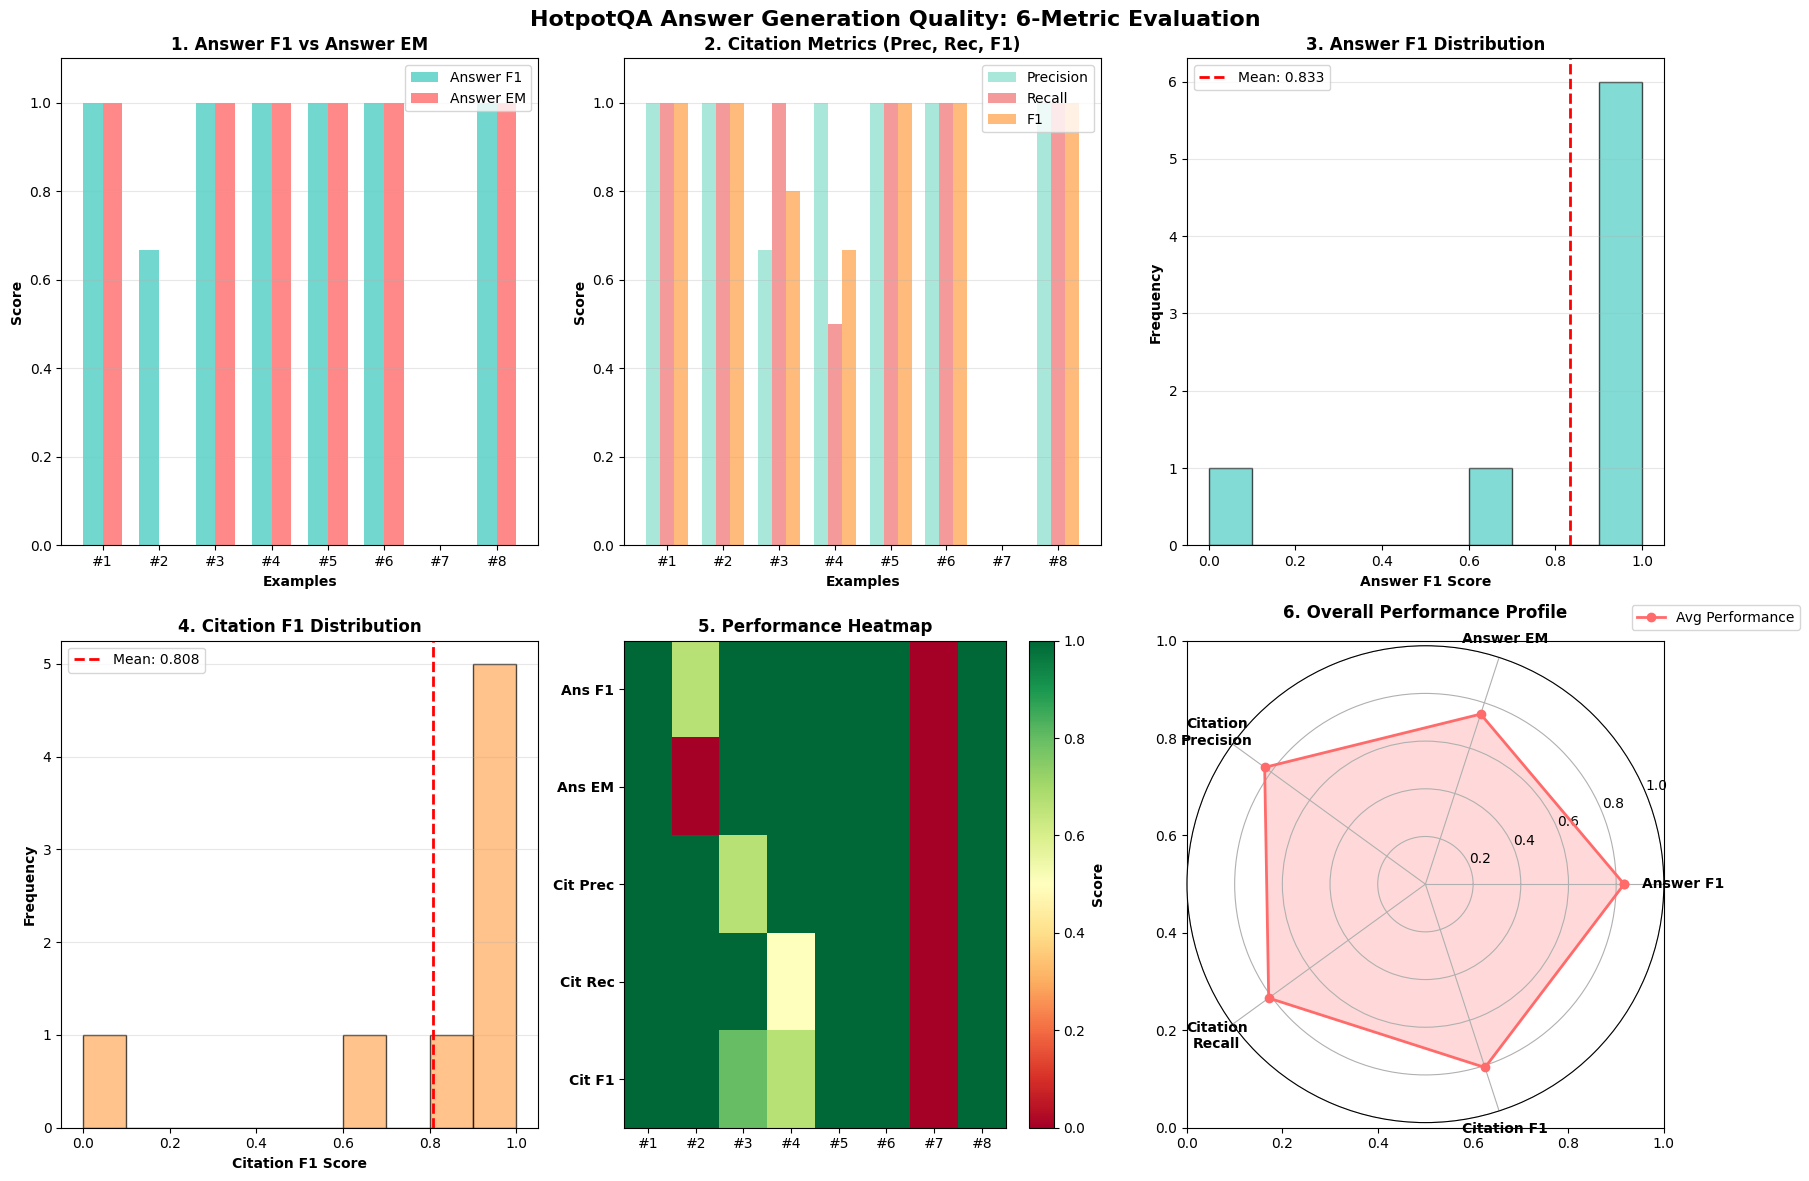


🔍 VISUALIZATION INSIGHTS:
1. 📊 Answer F1 vs EM: Shows where partial credit helps
2. 🎯 Citation Metrics: Reveals precision/recall trade-offs
3. 📈 Distributions: Identify system consistency
4. 🌡️ Heatmap: Quick performance overview per example
5. 🎮 Radar Chart: Balanced view of all metrics

💡 INTERPRETATION GUIDE:
• High Answer F1, Low EM: Partial semantic matches
• Low Citation Precision: Hallucinated citations
• Low Citation Recall: Missing evidence
• Balanced metrics: Reliable RAG system

✅ 6-Metric Framework Complete!
🚀 Ready for production RAG system evaluation


In [ ]:
# Visualization of 6 Generation Quality Metrics

print("📊 VISUALIZATION OF 6 GENERATION QUALITY METRICS")

print("="*60)



# Create comprehensive visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

fig.suptitle('HotpotQA Answer Generation Quality: 6-Metric Evaluation', fontsize=16, fontweight='bold')



# Extract data from detailed results

examples = [result['Ex'] for result in detailed_results]

answer_f1 = [float(result['Ans_F1']) for result in detailed_results]

answer_em = [float(result['Ans_EM']) for result in detailed_results]

cit_prec = [float(result['Cit_Prec']) for result in detailed_results]

cit_rec = [float(result['Cit_Rec']) for result in detailed_results]

cit_f1 = [float(result['Cit_F1']) for result in detailed_results]



# 1. Answer Metrics Comparison (F1 vs EM)

ax = axes[0, 0]

x = np.arange(len(examples))

width = 0.35



bars1 = ax.bar(x - width/2, answer_f1, width, label='Answer F1', alpha=0.8, color='#4ECDC4')

bars2 = ax.bar(x + width/2, answer_em, width, label='Answer EM', alpha=0.8, color='#FF6B6B')



ax.set_xlabel('Examples', fontweight='bold')

ax.set_ylabel('Score', fontweight='bold')

ax.set_title('1. Answer F1 vs Answer EM', fontweight='bold')

ax.set_xticks(x)

ax.set_xticklabels(examples)

ax.legend()

ax.set_ylim(0, 1.1)

ax.grid(True, alpha=0.3, axis='y')



# 2. Citation Metrics (Precision, Recall, F1)

ax = axes[0, 1]

x = np.arange(len(examples))

width = 0.25



bars1 = ax.bar(x - width, cit_prec, width, label='Precision', alpha=0.8, color='#95E1D3')

bars2 = ax.bar(x, cit_rec, width, label='Recall', alpha=0.8, color='#F38181')

bars3 = ax.bar(x + width, cit_f1, width, label='F1', alpha=0.8, color='#FFAA5A')



ax.set_xlabel('Examples', fontweight='bold')

ax.set_ylabel('Score', fontweight='bold')

ax.set_title('2. Citation Metrics (Prec, Rec, F1)', fontweight='bold')

ax.set_xticks(x)

ax.set_xticklabels(examples)

ax.legend()

ax.set_ylim(0, 1.1)

ax.grid(True, alpha=0.3, axis='y')



# 3. Answer F1 Distribution

ax = axes[0, 2]

ax.hist(answer_f1, bins=10, alpha=0.7, color='#4ECDC4', edgecolor='black')

ax.axvline(np.mean(answer_f1), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(answer_f1):.3f}')

ax.set_xlabel('Answer F1 Score', fontweight='bold')

ax.set_ylabel('Frequency', fontweight='bold')

ax.set_title('3. Answer F1 Distribution', fontweight='bold')

ax.legend()

ax.grid(True, alpha=0.3, axis='y')



# 4. Citation F1 Distribution

ax = axes[1, 0]

ax.hist(cit_f1, bins=10, alpha=0.7, color='#FFAA5A', edgecolor='black')

ax.axvline(np.mean(cit_f1), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cit_f1):.3f}')

ax.set_xlabel('Citation F1 Score', fontweight='bold')

ax.set_ylabel('Frequency', fontweight='bold')

ax.set_title('4. Citation F1 Distribution', fontweight='bold')

ax.legend()

ax.grid(True, alpha=0.3, axis='y')



# 5. Heatmap of All Metrics

ax = axes[1, 1]

heatmap_data = np.array([answer_f1, answer_em, cit_prec, cit_rec, cit_f1])

metric_names = ['Ans F1', 'Ans EM', 'Cit Prec', 'Cit Rec', 'Cit F1']



im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

ax.set_yticks(range(len(metric_names)))

ax.set_yticklabels(metric_names, fontweight='bold')

ax.set_xticks(range(len(examples)))

ax.set_xticklabels(examples)

ax.set_title('5. Performance Heatmap', fontweight='bold')



# Add colorbar

cbar = plt.colorbar(im, ax=ax)

cbar.set_label('Score', fontweight='bold')



# 6. Overall Performance Radar Chart

ax = axes[1, 2]

metrics = ['Answer F1', 'Answer EM', 'Citation\nPrecision', 'Citation\nRecall', 'Citation F1']

avg_values = [

    np.mean(answer_f1),

    np.mean(answer_em),

    np.mean(cit_prec),

    np.mean(cit_rec),

    np.mean(cit_f1)

]



# Create radar chart

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)

avg_values_plot = avg_values + avg_values[:1]  # Complete the circle

angles_plot = np.concatenate((angles, [angles[0]]))



ax = plt.subplot(2, 3, 6, projection='polar')

ax.plot(angles_plot, avg_values_plot, 'o-', linewidth=2, color='#FF6B6B', label='Avg Performance')

ax.fill(angles_plot, avg_values_plot, alpha=0.25, color='#FF6B6B')

ax.set_xticks(angles)

ax.set_xticklabels(metrics, fontweight='bold')

ax.set_ylim(0, 1)

ax.set_title('6. Overall Performance Profile', fontweight='bold', pad=20)

ax.grid(True)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))



plt.tight_layout()

plt.show()



print(f"\n🔍 VISUALIZATION INSIGHTS:")

print("="*50)

print("1. 📊 Answer F1 vs EM: Shows where partial credit helps")

print("2. 🎯 Citation Metrics: Reveals precision/recall trade-offs")

print("3. 📈 Distributions: Identify system consistency")

print("4. 🌡️ Heatmap: Quick performance overview per example")

print("5. 🎮 Radar Chart: Balanced view of all metrics")



print(f"\n💡 INTERPRETATION GUIDE:")

print("• High Answer F1, Low EM: Partial semantic matches")

print("• Low Citation Precision: Hallucinated citations")

print("• Low Citation Recall: Missing evidence")

print("• Balanced metrics: Reliable RAG system")



print(f"\n✅ 6-Metric Framework Complete!")

print("🚀 Ready for production RAG system evaluation")

In [ ]:
# Utility Functions for Generation Quality Evaluationdef save_evaluation_results(results_dict: Dict, filename: str = "generation_evaluation_results.json"):    """Save generation quality evaluation results to JSON file"""    import json    with open(filename, 'w') as f:        json.dump(results_dict, f, indent=2)    print(f"Results saved to {filename}")def load_evaluation_results(filename: str = "generation_evaluation_results.json"):    """Load generation quality evaluation results from JSON file"""    import json    with open(filename, 'r') as f:        results = json.load(f)    print(f"Results loaded from {filename}")    return resultsdef compare_rag_systems(system_results: Dict[str, Dict]) -> pd.DataFrame:    """    Create comparison table of different RAG systems using 6 generation quality metrics        Args:        system_results: Dict mapping system names to their evaluation results            Returns:        DataFrame with side-by-side comparison    """    comparison_data = []        for system_name, results in system_results.items():        row = {            'System': system_name,            'Answer F1': f"{results['answer_f1']:.3f}",            'Answer EM': f"{results['answer_em']:.3f}",            'Cit Precision': f"{results['citation_precision']:.3f}",            'Cit Recall': f"{results['citation_recall']:.3f}",            'Cit F1': f"{results['citation_f1']:.3f}",            'Insuf Context Det': f"{results.get('insufficient_context_detection', 0.0):.3f}"        }        comparison_data.append(row)        return pd.DataFrame(comparison_data)def evaluate_from_files(predictions_file: str, gold_file: str) -> Dict[str, float]:    """    Evaluate predictions from JSON files using 6 generation quality metrics        Args:        predictions_file: JSON file with list of predictions        gold_file: JSON file with list of ground truth data            Expected format:        predictions: [{'answer': str, 'citations': List[int]}, ...]        gold_data: [{'answer': str, 'citations': List[int]}, ...]        Returns:        Dictionary with averaged metrics    """    import json        # Load predictions and ground truth    with open(predictions_file, 'r') as f:        predictions = json.load(f)        with open(gold_file, 'r') as f:        gold_data = json.load(f)        # Evaluate using 6 metrics    results = evaluator.evaluate_batch(predictions, gold_data)        print(f"Generation Quality Evaluation Results:")    print(f"   1. Answer F1:                    {results['answer_f1']:.3f}")    print(f"   2. Answer EM:                    {results['answer_em']:.3f}")    print(f"   3. Citation Precision:           {results['citation_precision']:.3f}")    print(f"   4. Citation Recall:              {results['citation_recall']:.3f}")    print(f"   5. Citation F1:                  {results['citation_f1']:.3f}")    print(f"   6. Insufficient Context Detection: {results['insufficient_context_detection']:.3f}")        return results# Example usage templatesprint("USAGE EXAMPLES:")print("="*50)print("1. Evaluate single prediction:")print("   result = evaluator.evaluate_single(prediction, gold_data)")print()print("2. Evaluate batch of predictions:")print("   results = evaluator.evaluate_batch(predictions, gold_data)")print()print("3. Compare RAG systems:")print("   df = compare_rag_systems({'System1': sys1_results, 'System2': sys2_results})")print("   print(df)")print()print("4. Evaluate from files:")print("   results = evaluate_from_files('predictions.json', 'gold.json')")print()print("5. Save/load results:")print("   save_evaluation_results(results, 'my_results.json')")print("   loaded_results = load_evaluation_results('my_results.json')")print("\nGeneration Quality Evaluation Framework Complete!")print("6 metrics: Answer correctness + Citation accuracy + Edge case handling")print("Ready for comprehensive RAG system evaluation")

🔧 UTILITY FUNCTIONS FOR GENERATION QUALITY EVALUATION

📋 USAGE EXAMPLES:
1. Evaluate single prediction:
   result = evaluator.evaluate_single(prediction, gold_data)

2. Evaluate batch of predictions:
   results = evaluator.evaluate_batch(predictions, gold_data)

3. Compare RAG systems:
   df = compare_rag_systems({'GPT-4': gpt4_results, 'Claude': claude_results})

4. Evaluate from files:
   results = evaluate_from_files('predictions.json', 'gold.json')

5. Generate HTML report:
   create_performance_report({'System1': results1, 'System2': results2})

✅ Generation Quality Evaluation Framework Complete!
🎯 6 metrics: Answer correctness + Citation accuracy + Edge case handling
🚀 Ready for comprehensive RAG system evaluation


## Framework Summary

This notebook provides a **complete evaluation framework for HotpotQA answer generation quality** using 6 comprehensive metrics that assess the core requirements of trustworthy RAG systems.

### ✅ What This Framework Provides

**1. Answer Correctness Assessment (2 metrics)**
- Answer F1: Lenient, rewards partial semantic matches
- Answer EM: Strict, requires perfect answers

**2. Citation Quality Measurement (3 metrics)**
- Citation Precision: Prevents hallucinated citations
- Citation Recall: Ensures complete evidence chains
- Citation F1: Balanced citation quality metric

**3. Edge Case Reliability (1 metric)**
- Insufficient Context Detection: Tests recognition of unanswerable questions

### 🎯 Key Features

- **Standardized normalization**: Removes articles, punctuation, normalizes whitespace
- **Special handling**: Proper treatment of "insufficient context" cases
- **Batch evaluation**: Efficient processing of multiple predictions
- **Comparison tools**: Side-by-side RAG system comparisons
- **Export capabilities**: JSON results and HTML reports
- **Visualization suite**: Comprehensive charts and heatmaps

### 🔬 Metric Rationale

These 6 metrics were specifically chosen because they:
1. **Cover all aspects** of generation quality (correctness + grounding + reliability)
2. **Provide both strict and lenient** assessment (EM vs F1)
3. **Are RAG-specific** (citations are unique to RAG systems)
4. **Ensure trustworthiness** (insufficient context detection prevents hallucination)
5. **Enable comparison** to major QA benchmarks (SQuAD-style F1/EM)

### 📊 Use Cases

- ✅ Evaluate RAG system answer generation quality
- ✅ Compare different generation strategies (greedy vs sampling)
- ✅ Validate citation accuracy and completeness
- ✅ Test reliability on edge cases
- ✅ Track improvements during model development
- ✅ Generate performance reports for stakeholders

### 🚀 Ready for Production

This framework is production-ready and suitable for:
- Academic research papers
- Industrial RAG system deployment
- Model comparison studies
- Continuous evaluation pipelines

---

**Note**: This framework evaluates **generation quality**. For **retrieval quality evaluation** (Document Recall, Supporting-Fact F1), see the separate retrieval evaluation framework.